## Table of Contents 
1. [Introduction](#table-of-contents)
    - 1.1 [Project Description](#introduction)
    - 1.2 [Imports](#imports)
    - 1.3 [Data Dictionary](#data-dictionary)
2. [Exploratory Data Analysis](#investigation-of-features)
3. [Data Transformation](#data-transformation)
    - 3.1 [Target Variable](#1-target-variable-cancer-type)
    - 3.2 [Genomic Features](#2-genonic-features)
    - 3.3 [Patient Features](#3-patient-features)
4. [Feature Engineering](#4-feature-engineering)
5. [Modelling](#modelling)
    - 5.1 [Logistic Regression](#51-logistic-regression-model)
    - 5.2 [Decision Tree Classifier](#52-deicision-tree-classifier)
    - 5.3 [K Nearest Neighbors](#53-k-nearest-neighbors)

## Introduction

The primary goal of this project is to determine the genetic and lifestyle characteristics that are most predictive of brain tumor type (between Low Grade Glioma and Glioblastoma Multiforme).

#### GOALS
* Two types of brain cancer, Glioma (GMA) and Glioblasoma (GBM).
Build a classificatin model that distinguishes beetween two types bsed on genomic data. Eg variant classification, tumor sequance, allele, model that distinguishes one type or another. 

## Imports

In [62]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns

# 
import matplotlib.pyplot as plt

# statsmodels imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

# import seaborn
import seaborn as sns

# genetic information imports
import re

### Data Dictionary

#### All Initial Features
| Field | Datatype | Description |
| --- | --- | --- |
| chrom | object | Chromosome
| chromStart | int64 | Start position in chromosome
| chromEnd | int64 | End position in chromosome
| name | object | Name of item
| score | int64 | Score from 0-1000
| strand | object | + or -
| thickStart | int64 | Start of where display should be thick (start codon)
| thickEnd | int64 | End of where display should be thick (stop codon)
| reserved | object | Used as itemRgb as of 2004-11-22
| blockCount | int64 | Number of blocks
| blockSizes | int64 | Comma separated list of block sizes
| chromStarts | int64 | Start positions relative to chromStart
| sampleCount | int64 | Number of samples with this variant
| freq | float64 | Variant frequency
| Hugo_Symbol | object | Symbol / nomenclature to identify each gene 
| Entrez_Gene_Id | int64 | Entrez Gene Id
| Variant_Classification | object | Class of variant
| Variant_Type | object | Type of variant
| Reference_Allele | object | Reference allele
| Tumor_Seq_Allele1 | object | Tumor allele 1
| Tumor_Seq_Allele2 | object | Tumor allele 2
| dbSNP_RS | object | dbSNP RS number
| dbSNP_Val_Status | object | dbSNP validation status
| days_to_death | object | Number of days till death
| cigarettes_per_day | object | Number of cigarettes per day
| weight | object | Weight
| alcohol_history | object | Any alcohol consumption?
| alcohol_intensity | object | Frequency of alcohol consumption
| bmi | object | Body mass index
| years_smoked | object | Number of years smoked
| height | object | Height
| gender | object | Gender
| project_id | object | TCGA Project id
| ethnicity | object | Ethnicity
| Tumor_Sample_Barcode | object |  Tumor sample barcode
| Matched_Norm_Sample_Barcode | object | Matched normal sample barcode
| case_id | object | Case ID 
| cancer_type | object | Low Grade Glioma (LGG) / Gliomablastoma (GBM)

#### Dropped Columns
* 'reserved'
    - There is only one value for this feature
* 'Tumor_Sample_Barcode'
    - This feature is not relevant for modelling
* 'Matched_Norm_Sample_Barcode'
    - This feature is not relevant for modelling
* 'case_id'
    - This feature is not relevant for modelling
* 'project_id'
    - This feature is not relevant for modelling

# Included Features

#### Genomic Location Information 
| Feature | Description |
| --- | --- |
| chrom | Chromosome where the mutation is located (e.g. "chr1") |
| chromStart & chromEnd | Precise position of the mutation on the chromosome |
| name | Simple description of the mutation (e.g., "C>T" means a C base was changed to a T) |
| strand | DNA strand information (indicated by ".") |

#### Mutation Details
| Feature | Description |
| --- | --- |
| Hugo_Symbol | Gene name affected by this mutation (e.g., "OR4F5", "MIR6723"). The Hugo symbol is the standard nomenclature for genes. |
| Variant_Classification | Type of mutation effect (e.g., "Silent" means it doesn't change the protein) |
| Variant_Type | Type of genetic change (SNP = Single Nucleotide Polymorphism) |
| Reference_Allele | The original DNA base at this position | 
| Tumor_Seq_Allele1 & Tumor_Seq_Allele2 | The observed DNA bases in the tumor |

In [63]:
cancer_df = pd.read_csv('data/somatic_variant_data.csv')

In [64]:
cancer_df.shape

(118321, 38)

In [65]:
cancer_df.head(3)

,"#""chrom""",chromStart,chromEnd,name,score,strand,thickStart,thickEnd,reserved,blockCount,...,bmi,years_smoked,height,gender,project_id,ethnicity,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,case_id,cancer_type
0,chr1,69665,69666,C>T,1,.,69665,69666,"0,0,0",1,...,--,--,--,female,TCGA-GBM,not hispanic or latino,TCGA-19-5956-01A-11D-1696-08,TCGA-19-5956-10A-01D-1696-08,7e70a318-3acc-42f3-8287-158a2199f0bc,GBM
1,chr1,634047,634048,G>A,1,.,634047,634048,"0,0,0",1,...,--,--,--,male,TCGA-GBM,not hispanic or latino,TCGA-06-1800-01A-01W-0643-08,TCGA-06-1800-10A-01W-0643-08,b1ce95bf-7441-4aac-8131-19a177d2b8ac,GBM
2,chr1,874213,874214,C>T,1,.,874213,874214,"0,0,0",1,...,--,--,--,female,TCGA-LGG,not hispanic or latino,TCGA-DU-6392-01A-11D-1705-08,TCGA-DU-6392-10A-01D-1705-08,fcd9e1c4-bddb-4856-844c-03df48fba499,LGG


In [66]:
cancer_df.describe()

,chromStart,chromEnd,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,sampleCount,freq,Entrez_Gene_Id
count,1.183210e+05,1.183210e+05,118321.000000,1.183210e+05,1.183210e+05,118321.0,118321.000000,118321.0,118321.000000,118321.000000,1.183210e+05
mean,7.692969e+07,7.692969e+07,2.649648,7.692969e+07,7.692969e+07,1.0,1.082403,0.0,2.649648,0.000260,5.479663e+05
std,5.736212e+07,5.736212e+07,22.077652,5.736212e+07,5.736212e+07,0.0,1.092125,0.0,22.077652,0.002168,6.941641e+06
min,1.484900e+04,1.485000e+04,1.000000,1.484900e+04,1.485000e+04,1.0,1.000000,0.0,1.000000,0.000098,0.000000e+00
25%,3.236279e+07,3.236279e+07,1.000000,3.236279e+07,3.236279e+07,1.0,1.000000,0.0,1.000000,0.000098,5.927000e+03
50%,6.189291e+07,6.189291e+07,1.000000,6.189291e+07,6.189291e+07,1.0,1.000000,0.0,1.000000,0.000098,2.341800e+04
75%,1.139896e+08,1.139896e+08,1.000000,1.139896e+08,1.139896e+08,1.0,1.000000,0.0,1.000000,0.000098,8.178800e+04
max,2.489182e+08,2.489182e+08,548.000000,2.489182e+08,2.489182e+08,1.0,87.000000,0.0,548.000000,0.053820,1.071335e+08


#### Null Values

In [67]:
# Count all the missing values in the DataFrame
cancer_df.isnull().sum()

#"chrom"                           0
chromStart                         0
chromEnd                           0
name                               0
score                              0
strand                             0
thickStart                         0
thickEnd                           0
reserved                           0
blockCount                         0
blockSizes                         0
chromStarts                        0
sampleCount                        0
freq                               0
Hugo_Symbol                        0
Entrez_Gene_Id                     0
Variant_Classification             0
Variant_Type                       0
Reference_Allele                   0
Tumor_Seq_Allele1                  0
Tumor_Seq_Allele2                  0
dbSNP_RS                       20171
dbSNP_Val_Status               97248
days_to_death                      0
cigarettes_per_day                 0
weight                             0
alcohol_history                    0
a

In [68]:
# look at the two features with missing values
cancer_df[['dbSNP_RS', 'dbSNP_Val_Status']].head()

,dbSNP_RS,dbSNP_Val_Status
0,novel,NaN
1,NaN,NaN
2,novel,NaN
3,novel,NaN
4,novel,NaN


In [69]:
cancer_df['dbSNP_RS'].value_counts()

dbSNP_RS
novel          70425
rs121913500      374
rs121913343       50
rs121913499       27
rs139236063       17
               ...  
rs780611504        1
rs778051530        1
rs142559400        1
rs77327288         1
rs777620757        1
Name: count, Length: 26461, dtype: int64

In [70]:
cancer_df['dbSNP_Val_Status'].value_counts()

dbSNP_Val_Status
byFrequency                                             7667
byCluster;byFrequency                                   3838
byCluster                                               2721
by1000G;byCluster                                       2526
by1000G;byCluster;byFrequency                           2347
by1000G                                                 1449
by1000G;byFrequency                                      414
by1000G;byCluster;byFrequency;byHapMap                    40
byCluster;byFrequency;byHapMap                            18
byCluster;byHapMap                                        14
byHapMap                                                   7
by1000G;byCluster;byFrequency;suspect                      7
by1000G;byCluster;byHapMap                                 5
byCluster;suspect                                          5
by1000G;byCluster;suspect                                  3
suspect                                                    2
byClust

Although these rows have missing values, they are not useful for our analysis


In [71]:
cancer_df1 = cancer_df.drop(['dbSNP_RS', 'dbSNP_Val_Status'], axis=1)
cancer_df1.isnull().sum()

#"chrom"                       0
chromStart                     0
chromEnd                       0
name                           0
score                          0
strand                         0
thickStart                     0
thickEnd                       0
reserved                       0
blockCount                     0
blockSizes                     0
chromStarts                    0
sampleCount                    0
freq                           0
Hugo_Symbol                    0
Entrez_Gene_Id                 0
Variant_Classification         0
Variant_Type                   0
Reference_Allele               0
Tumor_Seq_Allele1              0
Tumor_Seq_Allele2              0
days_to_death                  0
cigarettes_per_day             0
weight                         0
alcohol_history                0
alcohol_intensity              0
bmi                            0
years_smoked                   0
height                         0
gender                         0
project_id

The features with missing values have been dropped.

#### Duplicates

In [72]:
# Check for duplicates
cancer_df1.duplicated().sum()

np.int64(0)

In [73]:
cancer_df['score']

0         1
1         1
2         1
3         1
4         1
         ..
118316    1
118317    1
118318    1
118319    1
118320    1
Name: score, Length: 118321, dtype: int64

There are no duplicate rows found in this dataframe.

The following features are dropped because the do not afford data that is useful for modelling. They contain sample id info used for organization of the samples rather than for modelling. 

#### Dropping Features
| Feature Dropped | Reason |
| --- | --- |
| 'case_id' | every instance has a unique 'case_id' therefore not of value for modelling |
| 'Matched_Norm_Sample_Barcode' | not relevant for modelling |
| 'Tumor_Sample_Barcode' | not relevant for modelling |
| 'score' | this column is ambiguous and the meaning of 'score' is unknown. What are they scoring? |
| 'strand' | this feature only contains one value |
| 'Hugo_Symbol' | This feature contains too many unique values to be effectively used for modelling | 

In [74]:
# drop the following columns
cancer_df1 = cancer_df1.drop(['case_id', 
                              'Matched_Norm_Sample_Barcode', 
                              'Tumor_Sample_Barcode',
                              'score',
                              'strand'], axis=1)

### Investigation of Features

In [75]:
cancer_df1['name'].value_counts()

name
G>A                    28471
C>T                    28093
G>T                     9669
C>A                     9657
T>C                     6990
                       ...  
insAGAAAAACACAAGAAT        1
insGACAGAGTGAGACTC         1
insGATTGATG                1
insAAG                     1
insTCTATTTTTAT             1
Name: count, Length: 1410, dtype: int64

In [76]:
cancer_df1['Hugo_Symbol'].value_counts()

Hugo_Symbol
TTN             478
TP53            429
IDH1            414
ATRX            244
MUC16           176
               ... 
DOHH              1
RP11-38C17.1      1
SDF4              1
FAM132A           1
UBE2J2            1
Name: count, Length: 18113, dtype: int64

The Hugo symbol is nomenclature used to identify genes. 

In [77]:
cancer_df1['reserved'].value_counts()

reserved
0,0,0    118321
Name: count, dtype: int64

In [78]:
# Sincnne the 'reserved' column has only one value, we can drop it
cancer_df1 = cancer_df1.drop('reserved', axis=1)

In [79]:
cancer_df1['Reference_Allele'].value_counts()

Reference_Allele
G                                     42458
C                                     41970
T                                     15292
A                                     14380
-                                      2879
                                      ...  
TCGCCTGTTAATTTTCTAAAAATAA                 1
GAGCAGATGTTGGTAAAGAGTCAAAGGCAGGAGA        1
CACGAAGGACTTGGTA                          1
AAGATCTGTTTACGTGA                         1
AGCTCGCTACTATAAA                          1
Name: count, Length: 529, dtype: int64

In [80]:
cancer_df1['Reference_Allele'].nunique()

529

In [81]:
cancer_df1['Reference_Allele'].value_counts()

Reference_Allele
G                                     42458
C                                     41970
T                                     15292
A                                     14380
-                                      2879
                                      ...  
TCGCCTGTTAATTTTCTAAAAATAA                 1
GAGCAGATGTTGGTAAAGAGTCAAAGGCAGGAGA        1
CACGAAGGACTTGGTA                          1
AAGATCTGTTTACGTGA                         1
AGCTCGCTACTATAAA                          1
Name: count, Length: 529, dtype: int64

In [82]:
cancer_df1['Hugo_Symbol'].nunique()

18113

Reference Allele
* The DNA base that is the standard sequence of a nucleotide (base) at a specific location in the reference genome (established sequence of DNA used to represent the standard version of the human genome). 

Hugo Symbol
* Standard nomenclature used to identify genes. 18,113 of the 47,977 HUGO symbols are found in this dataset. 

Ordinal encoding? Creating a class system?

In [83]:
cancer_df1['cancer_type'].value_counts()

cancer_type
GBM    82765
LGG    35556
Name: count, dtype: int64

<Axes: title={'center': 'Cancer Type Counts'}, xlabel='cancer_type'>

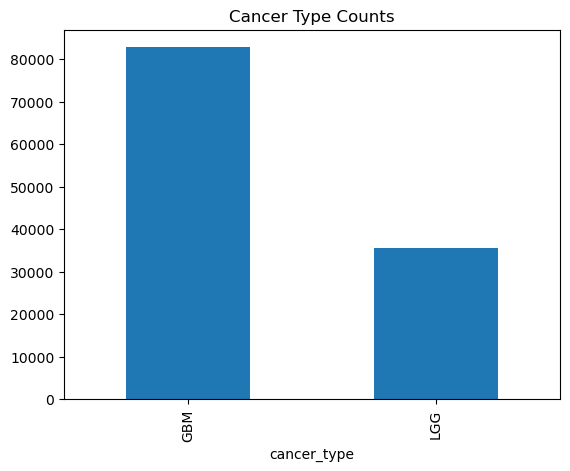

In [84]:
cancer_df1['cancer_type'].value_counts().plot(kind='bar',
                                                   title='Cancer Type Counts')

Because there are only two values in the target variable, binary encoding will suffice. 

In [85]:
cancer_df['Variant_Classification'].value_counts()


Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

There are 19 types of Variant Classification

In [86]:
cancer_df['Variant_Type'].value_counts()

Variant_Type
SNP    112187
DEL      3255
INS      2879
Name: count, dtype: int64

* SNP (single nucleotide polymorphism): 
    - When one nucleotide (A, T, C, G) in a DNA sequence differs from a referene sequence. 
* DEL (deletion): 
    - Where a segment of DNA is lost or removed from its normal position in the genome.
* INS (insertion): 
    - Where one or more nucleotides are added to a DNA sequence.

Drop the 'strand' and 'reserved' columns as they have only one data value

In [87]:
cancer_df1 = cancer_df.drop(['strand',
                            'reserved',
                            'case_id', 
                            'Matched_Norm_Sample_Barcode', 
                            'Tumor_Sample_Barcode'], axis=1)
                            
                            

In [88]:
cancer_df1.head()

,"#""chrom""",chromStart,chromEnd,name,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,...,weight,alcohol_history,alcohol_intensity,bmi,years_smoked,height,gender,project_id,ethnicity,cancer_type
0,chr1,69665,69666,C>T,1,69665,69666,1,1,0,...,--,--,--,--,--,--,female,TCGA-GBM,not hispanic or latino,GBM
1,chr1,634047,634048,G>A,1,634047,634048,1,1,0,...,--,--,--,--,--,--,male,TCGA-GBM,not hispanic or latino,GBM
2,chr1,874213,874214,C>T,1,874213,874214,1,1,0,...,--,--,--,--,--,--,female,TCGA-LGG,not hispanic or latino,LGG
3,chr1,874359,874360,T>G,1,874359,874360,1,1,0,...,--,--,--,--,--,--,female,TCGA-GBM,not hispanic or latino,GBM
4,chr1,925927,925928,G>C,1,925927,925928,1,1,0,...,--,--,--,--,--,--,male,TCGA-LGG,not hispanic or latino,LGG


# Data Transformation

### 1. Target Variable (Cancer Type)
 - Binary encode (LGG -> 0, GBM -> 1)

In [89]:
cancer_df1['cancer_type'].value_counts()

cancer_type
GBM    82765
LGG    35556
Name: count, dtype: int64

In [90]:
# Binary encode the cancer_type column LGG = 0, GBM = 1
cancer_df1['cancer_type'] = cancer_df1['cancer_type'].apply(lambda x: 0 if x == 'LGG' else 1)

In [91]:
# Check to see if the encoding was successful
cancer_df1['cancer_type'].value_counts()

cancer_type
1    82765
0    35556
Name: count, dtype: int64

### 2. Genonic Features

#### 'chrom' 
 - one-hot encode chromosomes (chr1, chr2, etc.)

In [92]:
# Change the "chrom" column to name to chrom
cancer_df1 = cancer_df1.rename(columns={'#"chrom"' : 'chrom'})

In [93]:
cancer_df1['chrom'].value_counts()

chrom
chr1     11860
chr2      8417
chr19     7664
chr17     7071
chr11     6878
chr3      6423
chr12     6327
chr7      6275
chr6      6070
chr5      5865
chrX      5765
chr4      4804
chr9      4584
chr16     4413
chr10     4408
chr8      3799
chr15     3760
chr14     3500
chr20     3005
chr22     2098
chr13     2037
chr18     1954
chr21     1280
chrY        64
Name: count, dtype: int64

In [94]:
# check to see if the encoding was successful
list(enumerate(cancer_df1.columns))

[(0, 'chrom'),
 (1, 'chromStart'),
 (2, 'chromEnd'),
 (3, 'name'),
 (4, 'score'),
 (5, 'thickStart'),
 (6, 'thickEnd'),
 (7, 'blockCount'),
 (8, 'blockSizes'),
 (9, 'chromStarts'),
 (10, 'sampleCount'),
 (11, 'freq'),
 (12, 'Hugo_Symbol'),
 (13, 'Entrez_Gene_Id'),
 (14, 'Variant_Classification'),
 (15, 'Variant_Type'),
 (16, 'Reference_Allele'),
 (17, 'Tumor_Seq_Allele1'),
 (18, 'Tumor_Seq_Allele2'),
 (19, 'dbSNP_RS'),
 (20, 'dbSNP_Val_Status'),
 (21, 'days_to_death'),
 (22, 'cigarettes_per_day'),
 (23, 'weight'),
 (24, 'alcohol_history'),
 (25, 'alcohol_intensity'),
 (26, 'bmi'),
 (27, 'years_smoked'),
 (28, 'height'),
 (29, 'gender'),
 (30, 'project_id'),
 (31, 'ethnicity'),
 (32, 'cancer_type')]

#### 'Variant_Classification'
 - one-hot encode (Silent, Missense, Nonsense, etc.)

In [95]:
cancer_df1['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

In [96]:
# create dummy variables for the 'Variant_Classification' column
cancer_df1 = pd.get_dummies(cancer_df1, columns=['Variant_Classification'],
                            dtype=int,
                            drop_first=True)

In [97]:
# check to see if the encoding was successful
cancer_df1.head()

,chrom,chromStart,chromEnd,name,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,...,Variant_Classification_In_Frame_Ins,Variant_Classification_Intron,Variant_Classification_Missense_Mutation,Variant_Classification_Nonsense_Mutation,Variant_Classification_Nonstop_Mutation,Variant_Classification_RNA,Variant_Classification_Silent,Variant_Classification_Splice_Region,Variant_Classification_Splice_Site,Variant_Classification_Translation_Start_Site
0,chr1,69665,69666,C>T,1,69665,69666,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,chr1,634047,634048,G>A,1,634047,634048,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,chr1,874213,874214,C>T,1,874213,874214,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,chr1,874359,874360,T>G,1,874359,874360,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,chr1,925927,925928,G>C,1,925927,925928,1,1,0,...,0,0,0,0,0,0,0,0,0,0


#### ' Variant_Type'
 - One-hot encode (SNP, INS, DEL, etc.)

In [98]:
cancer_df1['Variant_Type'].value_counts()

Variant_Type
SNP    112187
DEL      3255
INS      2879
Name: count, dtype: int64

In [99]:
# Create dummy variables for the 'Variant_Type' feature
cancer_df1 = pd.get_dummies(cancer_df1, columns=['Variant_Type'],
                            dtype=int,
                            drop_first=True)

#### 'Hugo_Symbol'
 - Frequency encoding (how common each gene is)

In [100]:
cancer_df1['Hugo_Symbol'].value_counts()

Hugo_Symbol
TTN             478
TP53            429
IDH1            414
ATRX            244
MUC16           176
               ... 
DOHH              1
RP11-38C17.1      1
SDF4              1
FAM132A           1
UBE2J2            1
Name: count, Length: 18113, dtype: int64

In [101]:
cancer_df1['Hugo_Symbol'].nunique()

18113

Since there are so many different unique Hugo_Symbol values we will drop the column

In [102]:
cancer_df1 = cancer_df1.drop('Hugo_Symbol', axis=1)

### 3. Patient Features


### Gender
 - Binary encod the 'gender' feature (female -> 0, male -> 1)

In [103]:
# Binary encode the 'gender' feature
cancer_df1['gender'] = cancer_df1['gender'].apply(lambda x: 0 if x == 'female' else 1)

In [104]:
cancer_df1['gender'].value_counts()

gender
0    70054
1    48267
Name: count, dtype: int64

# 4. Feature Engineering

chromStart, chromEnd: Use as is, but consider:
 - Chromosome-normalized position (position + chromosome length)
 - Distance from centromere or telomere


## 4.1 Genomic Context Features

### Mutation Length 
- mutation_length = chromEnd - chromStart

In [105]:
# Create a new feature called 'mutation_length'
# which is the difference between the chrromEnd and chromStart columns

cancer_df1['mutation_length'] = cancer_df1['chromEnd'] - cancer_df1['chromStart']
cancer_df1['mutation_length'].value_counts()

mutation_length
1     114100
2       3313
4        318
3        238
5         75
6         34
12        21
7         20
9         18
13        15
11        14
17        12
21        11
8         11
19        10
10         9
14         8
20         8
16         8
23         7
27         5
18         5
30         5
22         4
28         4
15         4
29         3
33         3
24         3
34         3
31         3
25         2
42         2
44         2
36         2
38         2
48         2
26         2
32         1
69         1
87         1
66         1
62         1
53         1
54         1
71         1
75         1
72         1
81         1
39         1
43         1
40         1
63         1
Name: count, dtype: int64

In [106]:
cancer_df1['Mut_Len_1-9'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 1 and x <= 9 else 0)
cancer_df1['Mut_Len_10-18'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 10 and x <= 18 else 0)
cancer_df1['Mut_Len_19-27'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 19 and x <= 27 else 0)
cancer_df1['Mut_Len_28-36'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 28 and x <= 36 else 0)
cancer_df1['Mut_Len_37-45'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 37 and x <= 45 else 0)
cancer_df1['Mut_Len_46-54'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 46 and x <= 54 else 0)
cancer_df1['Mut_Len_55-63'] = cancer_df1['mutation_length'].apply(lambda x: 1 if x >= 55 and x <= 63 else 0)

### Exonic 
 -  is_exonic (boolean): Flag if mutation is in a protein-coding region

In [107]:
# in the 'Variant_Classification' column, if the value is '

### Gene Family
 - Group genes by biological function/family

### Chromosome Group 
 - Group chromosomes (sex chromosomes vs. autosomes)
    - Sex chromosomes: 'chrX' and 'chrY'
    - Autosomes: 'chr1' through 'chr22'



cancer_df1['chromStart'].head()

In [108]:
cancer_df1['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chrX', 'chrY', 'chr10', 'chr11', 'chr12', 'chr13',
       'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
       'chr21', 'chr22'], dtype=object)

<Axes: title={'center': 'Chrom Count'}, xlabel='chrom'>

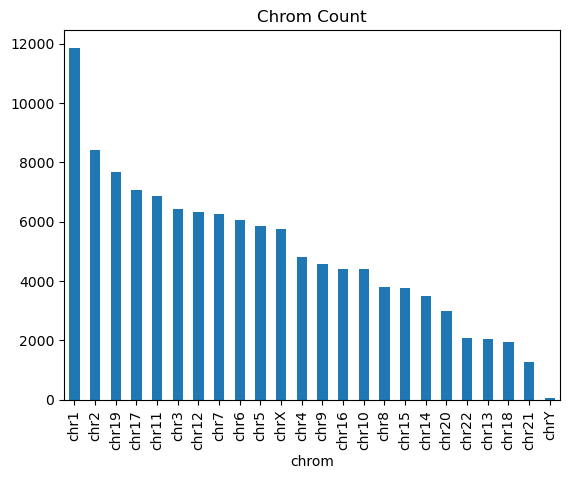

In [109]:
# create a graph of the chrom column for each cancer type
cancer_df1['chrom'].value_counts().plot(kind='bar',
                                        title='Chrom Count')

<Axes: title={'center': 'Cancer Type Count'}, xlabel='cancer_type'>

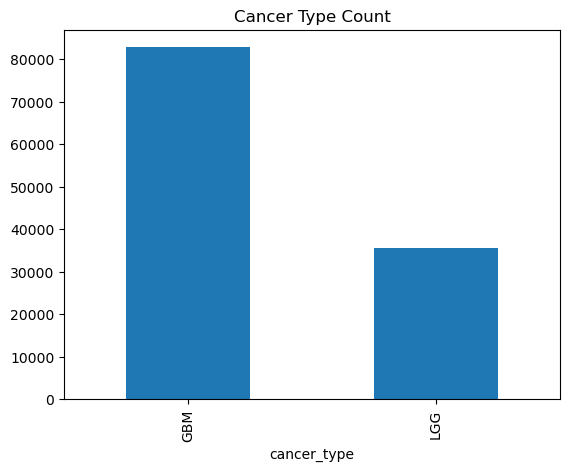

In [110]:
# show a bar chaert for the distribution of each cancer type
cancer_df['cancer_type'].value_counts().plot(kind='bar',
                                              title='Cancer Type Count')

In [111]:
# create a feature called 'autosome' which is 1 if the chrom column includes a number
cancer_df1['autosome'] = cancer_df1['chrom'].apply(lambda x: 1 if re.search(r'\d', x) else 0)

# create a feature called 'sex_chromosome' which is 1 if the chrom column includes an 'X' or 'Y'
cancer_df1['sex_chromosome'] = cancer_df1['chrom'].apply(lambda x: 1 if re.search(r'[XY]', x) else 0)

In [112]:
# Check the value counts for the 'autosome' column
cancer_df1['autosome'].value_counts()

autosome
1    112492
0      5829
Name: count, dtype: int64

In [113]:
# Check the value counts for the 'sex_chromosome' column
cancer_df1['sex_chromosome'].value_counts()

sex_chromosome
0    112492
1      5829
Name: count, dtype: int64

## 4.2 Mutation Characteristics

### Transition vs Transversion
Flag for mutation type
 - Transitions
    * A>G
    * C>T
- Transversions
    * A>T
    * G>C
    * C>A
    * T>G


In [114]:
cancer_df1['name'].value_counts()

name
G>A                    28471
C>T                    28093
G>T                     9669
C>A                     9657
T>C                     6990
                       ...  
insAGAAAAACACAAGAAT        1
insGACAGAGTGAGACTC         1
insGATTGATG                1
insAAG                     1
insTCTATTTTTAT             1
Name: count, Length: 1410, dtype: int64

In [115]:
# Create two new features based on the 'name' column, wich has the mutation type
# create a feature called 'mutation_transition' which is 1 if the mutation type is 'A>G' or 'C>T' and 0 otherwise
cancer_df1['mutation_transition'] = cancer_df1['name'].apply(lambda x: 1 if x == 'A>G' or x == 'C>T' else 0)

# create a feature called 'mutation_transversion' which is 1 if the muation type is 'A>T', 'G>C', 'C>A', or 'T>G'
cancer_df1['mutation_transversion'] = cancer_df1['name'].apply(lambda x: 1 if x == 'A>T' or x == 'G>C' or x == 'C>A' or x == 'T>G' else 0)

# create a feature called 'mutation_other' if neither of these conditions are met
cancer_df1['mutation_other'] = cancer_df1['name'].apply(lambda x: 1 if x != 'A>G' and x != 'C>T' and x != 'A>T' and x != 'G>C' and x != 'C>A' and x != 'T>G' else 0)

# drop the 'name' column
cancer_df1 = cancer_df1.drop('name', axis=1)

# See a dataframe with these new features only
cancer_df1[['mutation_transition', 'mutation_transversion', 'mutation_other']].head()

,mutation_transition,mutation_transversion,mutation_other
0,1,0,0
1,0,0,1
2,1,0,0
3,0,1,0
4,0,1,0


### CpG Site
 - Flag if mutation occurs at a CpG site (often hypermutable)

In [116]:
cancer_df1['Reference_Allele'].value_counts()

Reference_Allele
G                                     42458
C                                     41970
T                                     15292
A                                     14380
-                                      2879
                                      ...  
TCGCCTGTTAATTTTCTAAAAATAA                 1
GAGCAGATGTTGGTAAAGAGTCAAAGGCAGGAGA        1
CACGAAGGACTTGGTA                          1
AAGATCTGTTTACGTGA                         1
AGCTCGCTACTATAAA                          1
Name: count, Length: 529, dtype: int64

In [117]:
# for the 'Reference_Allele' column, create a new column called 'CpG_Site' which is 1 if the reference allele starts with 'CG' and 0 otherwise
cancer_df1['CpG_Site'] = cancer_df1['Reference_Allele'].apply(lambda x: 1 if x.startswith('CG') else 0)

In [118]:
cancer_df1['CpG_Site'].value_counts()

CpG_Site
0    118303
1        18
Name: count, dtype: int64

### Functional Impact
 - Combine Variant_Classification into severity groups


In [119]:
cancer_df1['Variant_Classification'] = cancer_df['Variant_Classification']

In [120]:
cancer_df1['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         68430
Silent                    23974
Nonsense_Mutation          5099
3'UTR                      4839
Intron                     4068
Frame_Shift_Del            2384
Frame_Shift_Ins            1887
5'UTR                      1874
RNA                        1646
Splice_Site                1384
Splice_Region              1061
3'Flank                     500
5'Flank                     466
In_Frame_Del                293
In_Frame_Ins                261
Translation_Start_Site       85
Nonstop_Mutation             64
IGR                           6
Name: count, dtype: int64

#### High Risk (4)
* Frame_Shift_Del / Frame_Shift_Ins (possibly combine these) 
    - Single / multiple nucleotides are removed -> leads to incorrect amino acids being added to a protein, leading to non-functionality of the protein. A stopcodon can be prematurely created, leading to shortened proteins. 
* Nonsense_Mutation (stop-gain variant)
    - Prematurely signals the cell to stop building a protein -> leads to a shortened and potentially non-functional protein
* Translation_Start_Site
    - Mutation in the initiation codon -> can lead to a non-functional protein. If protective proteins are not produced this can drive carcinogenesis. 
#### Mild - High (3)
* 3'UTR
    - Mutation in the region of mRNA that is the vital element for regulating gene expression -> leads to disruption of gene expression, especially in genes involved with cancer pathways. 
* 5'UTR
    - A region of mRNA important for regulating translation initiation, which influences how efficiently mRNA is translated into protein ->  impacts gene expression and gene production.
* RNA 
    - High mutation rates -> rapid adaptation. Leads to interference with normal protein production and disruption of gene expression. 
* Splice_Site / Splice_Region
    - Alter process of RNA splicing. 
* 3'Flank
    - Located downstream of protein coding sequence. Can effect gene expression. Severity dependent on location of the mutation. 
* 5'Flank
    - If this tumor occurs at the 5' flank region of oncogenes it can lead to tumor growth. 
* Nonstop_Mutation
    - A stop codon is transformed into a amino acid - encoding codon -> leads to an extended protein sequence which can be unstable. 
#### Mild Risk (2)
* Missense_Mutation
    - A single nucleotide substitution -> leads to a different amino acid incorporation into a protein. Potentially affects protein function.
* Intron 
    - Variations in non-coding DNA region -> can effect RNA splicing or alter gene expression.
* In_Frame_Del
    - Reading frame remains intact and impact depends size of deletion and protein function. 
* In_Frame_Ins
    - The reading frame remains intact. Severity depends on location and function of protein. 
#### Low Risk (1)
* Silent
    - A change in the DNA sequence that does not alter the resulting protein sequence -> new codon still codes for the same amino acid.

#### Uncertain
* IGR mutation
    - Rearrangements of DNA sequences within a gene. Specific role of IGR mutation is still being studied. 

In [121]:
# Ordinal encode the 'Variant_Classification' column into the following categories
# 1 - Low Risk
# 2 - Mild Risk
# 3 - Mild - High Risk
# 4 - High Risk

# Ensure the 'Variant_Classification' column is present in cancer_df1
cancer_df1['Variant_Classification'] = cancer_df['Variant_Classification']

# create a feature called 'Variant_Severity' 
cancer_df1['Variant_Severity'] = cancer_df1['Variant_Classification'].apply(
    lambda x: 4 if x in ['Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_Mutation', 'Translation_Start_Site'] 
    else 3 if x in ["3'UTR", "5'UTR", 'RNA', 'Splice_Site', 'Splice_Region', "3'Flank", "5'Flank", 'Nonstop_Mutation']
    else 2 if x in ['Missense_Mutation', 'Intron', 'In_Frame_Del', 'In_Frame_Ins']
    else 1 if x in ['Silent']
    else 0
)

In [122]:
cancer_df1['Variant_Severity'].value_counts()

Variant_Severity
2    73052
1    23974
3    11834
4     9455
0        6
Name: count, dtype: int64

## 4.3 Advanced Genomic Features

### Gene Expression Cluster
 - If you have gene expression data


### Mutation Burden
 - mutation_burden: Count of mutations per patient


### Pathway Impact
 - pathway_impact: Aggregate mutations by biological pathway

## 4.4 Interaction Features
 - gender × gene: Some mutations have gender-specific effects 

## Genetic Information Data Frame

In [123]:
# drop all of the columns that have patient data in them since we are not interested in that information
genetic_df = cancer_df1.drop(['ethnicity', 'gender', 'height', 'years_smoked',
                              'bmi', 'alcohol_intensity', 'alcohol_history',
                              'weight', 'cigarettes_per_day', 'days_to_death'], axis=1)

In [124]:
genetic_df.head()

,chrom,chromStart,chromEnd,score,thickStart,thickEnd,blockCount,blockSizes,chromStarts,sampleCount,...,Mut_Len_46-54,Mut_Len_55-63,autosome,sex_chromosome,mutation_transition,mutation_transversion,mutation_other,CpG_Site,Variant_Classification,Variant_Severity
0,chr1,69665,69666,1,69665,69666,1,1,0,1,...,0,0,1,0,1,0,0,0,Silent,1
1,chr1,634047,634048,1,634047,634048,1,1,0,1,...,0,0,1,0,0,0,1,0,5'Flank,3
2,chr1,874213,874214,1,874213,874214,1,1,0,1,...,0,0,1,0,1,0,0,0,RNA,3
3,chr1,874359,874360,1,874359,874360,1,1,0,1,...,0,0,1,0,0,1,0,0,RNA,3
4,chr1,925927,925928,1,925927,925928,1,1,0,1,...,0,0,1,0,0,1,0,0,5'UTR,3


In [125]:
# show a list of thickStart - thickEnd values
thick_length = genetic_df['thickEnd'] - genetic_df['thickStart']
thick_length.value_counts()

1     114100
2       3313
4        318
3        238
5         75
6         34
12        21
7         20
9         18
13        15
11        14
17        12
21        11
8         11
19        10
10         9
14         8
20         8
16         8
23         7
27         5
18         5
30         5
22         4
28         4
15         4
29         3
33         3
24         3
34         3
31         3
25         2
42         2
44         2
36         2
38         2
48         2
26         2
32         1
69         1
87         1
66         1
62         1
53         1
54         1
71         1
75         1
72         1
81         1
39         1
43         1
40         1
63         1
Name: count, dtype: int64

In [126]:
# We will drop the thickStart and thickEnd columns
genetic_df = genetic_df.drop(['thickStart', 'thickEnd'], axis=1)

In [127]:
list(enumerate(genetic_df.columns))

[(0, 'chrom'),
 (1, 'chromStart'),
 (2, 'chromEnd'),
 (3, 'score'),
 (4, 'blockCount'),
 (5, 'blockSizes'),
 (6, 'chromStarts'),
 (7, 'sampleCount'),
 (8, 'freq'),
 (9, 'Entrez_Gene_Id'),
 (10, 'Reference_Allele'),
 (11, 'Tumor_Seq_Allele1'),
 (12, 'Tumor_Seq_Allele2'),
 (13, 'dbSNP_RS'),
 (14, 'dbSNP_Val_Status'),
 (15, 'project_id'),
 (16, 'cancer_type'),
 (17, "Variant_Classification_3'UTR"),
 (18, "Variant_Classification_5'Flank"),
 (19, "Variant_Classification_5'UTR"),
 (20, 'Variant_Classification_Frame_Shift_Del'),
 (21, 'Variant_Classification_Frame_Shift_Ins'),
 (22, 'Variant_Classification_IGR'),
 (23, 'Variant_Classification_In_Frame_Del'),
 (24, 'Variant_Classification_In_Frame_Ins'),
 (25, 'Variant_Classification_Intron'),
 (26, 'Variant_Classification_Missense_Mutation'),
 (27, 'Variant_Classification_Nonsense_Mutation'),
 (28, 'Variant_Classification_Nonstop_Mutation'),
 (29, 'Variant_Classification_RNA'),
 (30, 'Variant_Classification_Silent'),
 (31, 'Variant_Classifica

In [128]:
genetic_df[['chromStarts', 'chromStart', 'chromEnd', 'project_id',
            'dbSNP_RS', 'dbSNP_Val_Status', 'score',
            'freq', 'chrom', 'blockCount', 'blockSizes', 'sampleCount', 'Entrez_Gene_Id',
            'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']].head()

,chromStarts,chromStart,chromEnd,project_id,dbSNP_RS,dbSNP_Val_Status,score,freq,chrom,blockCount,blockSizes,sampleCount,Entrez_Gene_Id,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2
0,0,69665,69666,TCGA-GBM,novel,NaN,1,0.000098,chr1,1,1,1,79501,C,C,T
1,0,634047,634048,TCGA-GBM,NaN,NaN,1,0.000098,chr1,1,1,1,102465432,G,G,A
2,0,874213,874214,TCGA-LGG,novel,NaN,1,0.000098,chr1,1,1,1,284593,C,C,T
3,0,874359,874360,TCGA-GBM,novel,NaN,1,0.000098,chr1,1,1,1,284593,T,T,G
4,0,925927,925928,TCGA-LGG,novel,NaN,1,0.000098,chr1,1,1,1,148398,G,G,C


In [129]:
genetic_df = genetic_df.drop(['chromStarts', 'chromStart', 'chromEnd', 'project_id',
            'dbSNP_RS', 'dbSNP_Val_Status', 'score',
            'freq', 'chrom', 'sampleCount', 'Entrez_Gene_Id',
            'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'Variant_Classification'], axis=1)

In [130]:
genetic_df.head()

,blockCount,blockSizes,cancer_type,Variant_Classification_3'UTR,Variant_Classification_5'Flank,Variant_Classification_5'UTR,Variant_Classification_Frame_Shift_Del,Variant_Classification_Frame_Shift_Ins,Variant_Classification_IGR,Variant_Classification_In_Frame_Del,...,Mut_Len_37-45,Mut_Len_46-54,Mut_Len_55-63,autosome,sex_chromosome,mutation_transition,mutation_transversion,mutation_other,CpG_Site,Variant_Severity
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,3
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3
4,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3


# Feature Selection

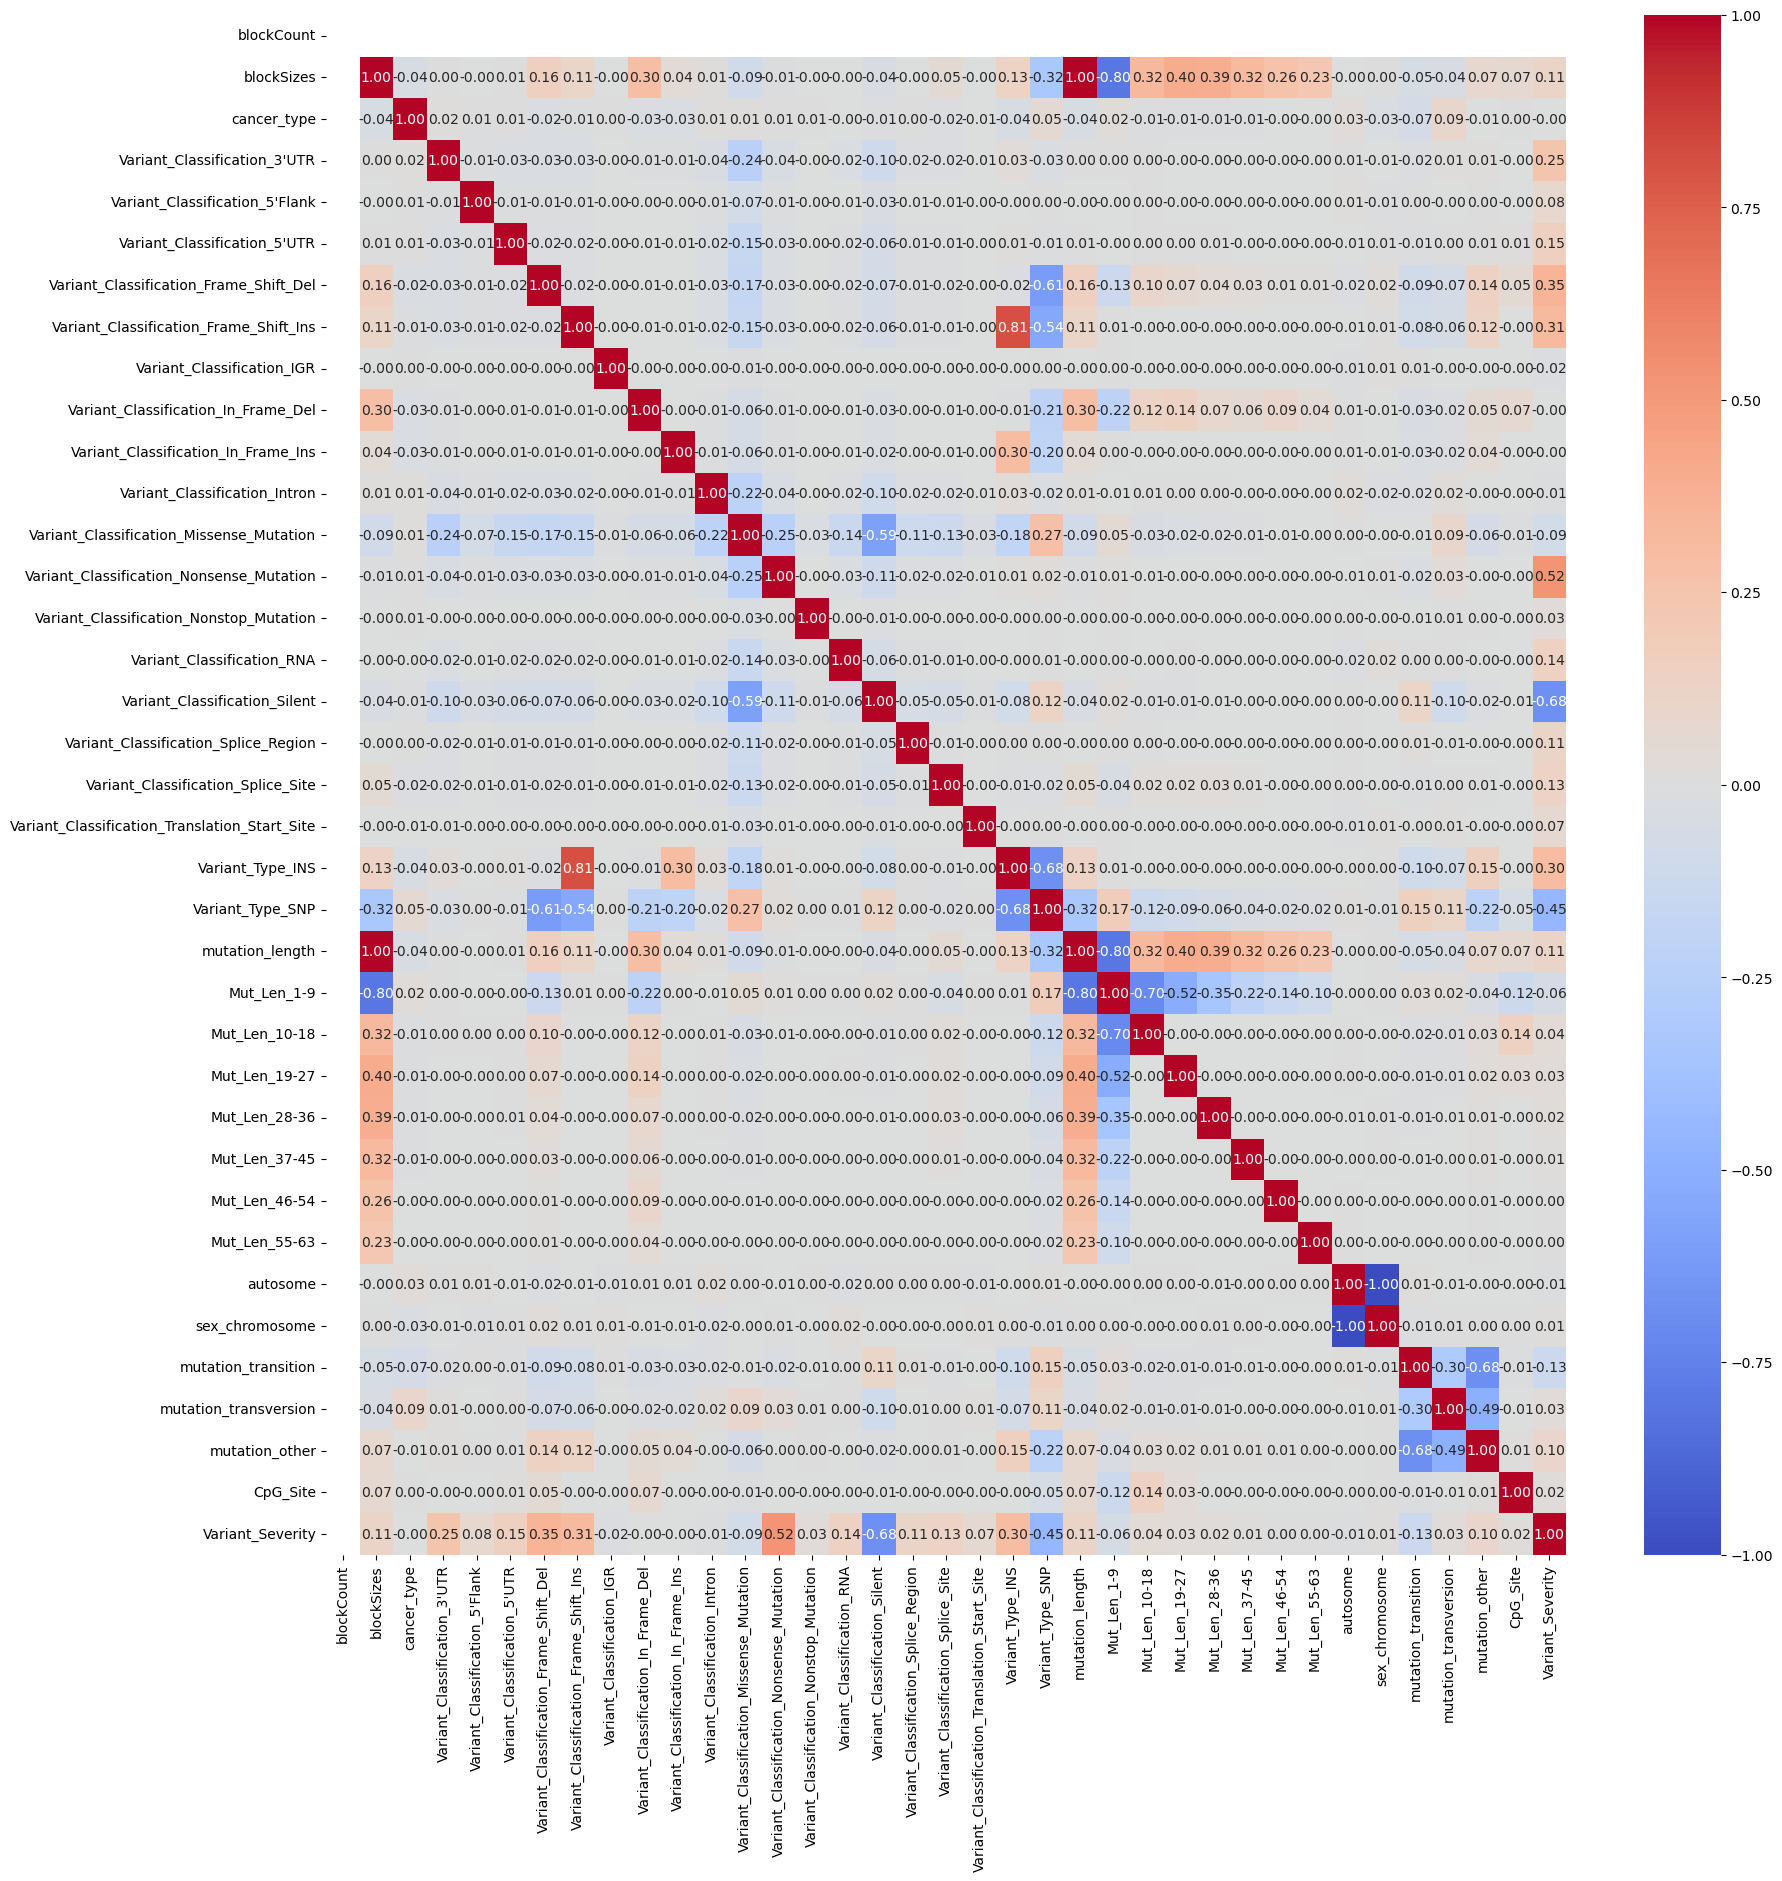

In [131]:
# Create a correlation matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(genetic_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


# EDA

In [132]:
# 1: Glioblastoma Multiforme (GBM)
# 0: Lower Grade Glioma (LGG)

genetic_df['cancer_type'].value_counts()



cancer_type
1    82765
0    35556
Name: count, dtype: int64

<Axes: title={'center': 'Cancer Type Counts'}, xlabel='cancer_type'>

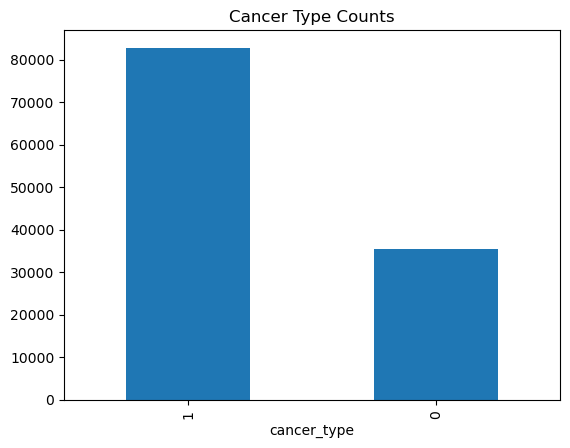

In [ ]:
cancer_df1['cancer_type'].value_counts().plot(kind='bar',
                                                   title='Cancer Type Counts')

# 5. Modelling

In [396]:
from tempfile import mkdtemp

## 5.1 Logistic Regression Model

1. Split the data
    - Divide the dataset into training and test sets (80:20 ratio).
2. Scaling parameters
    - Standard Scaler will be used
3. Scale the Training Data
    - Apply the scaling transformation to the training data
4. Fit the model
    - Train the model using the scaled training data
5. Scale the test data
    - Scale the test data before making predictions. 
6. Evaluate model performance
    - Using the scaled test data, evaluate the model's performance (accuracy, precision, recall, F1-score)

* Regularization: Lasso regularization will be used
* Scaler: StandardScaler will be used

In [133]:
# create a logistic regression model
X = genetic_df.drop(columns=['cancer_type'])
y = genetic_df['cancer_type']

In [134]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import PCA
from tempfile import mkdtemp

cachedir = mkdtemp()

estimators = [('normalise', StandardScaler()),
              ('PCA_model', PCA(n_components=15)),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators, memory = cachedir, verbose = True)

param_grid = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler(), None],
             'model__penalty': ['l1', 'l2'],
             'model__solver': ['saga', 'liblinear'],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 15]}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
fittedgrid = grid.fit(X_train, y_train)

In [60]:
# Show the best parameters from the pipeline
fittedgrid.best_params_

NameError: name 'fittedgrid' is not defined

In [136]:
# Instantiate the model
logreg_model = LogisticRegression(C=1, penalty='l2', solver='liblinear')
logreg_model.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [137]:
# Make predictions on the test set
y_pred_lr = logreg_model.predict(X_test)
y_prob_lr = logreg_model.predict_proba(X_test)[:, 1]

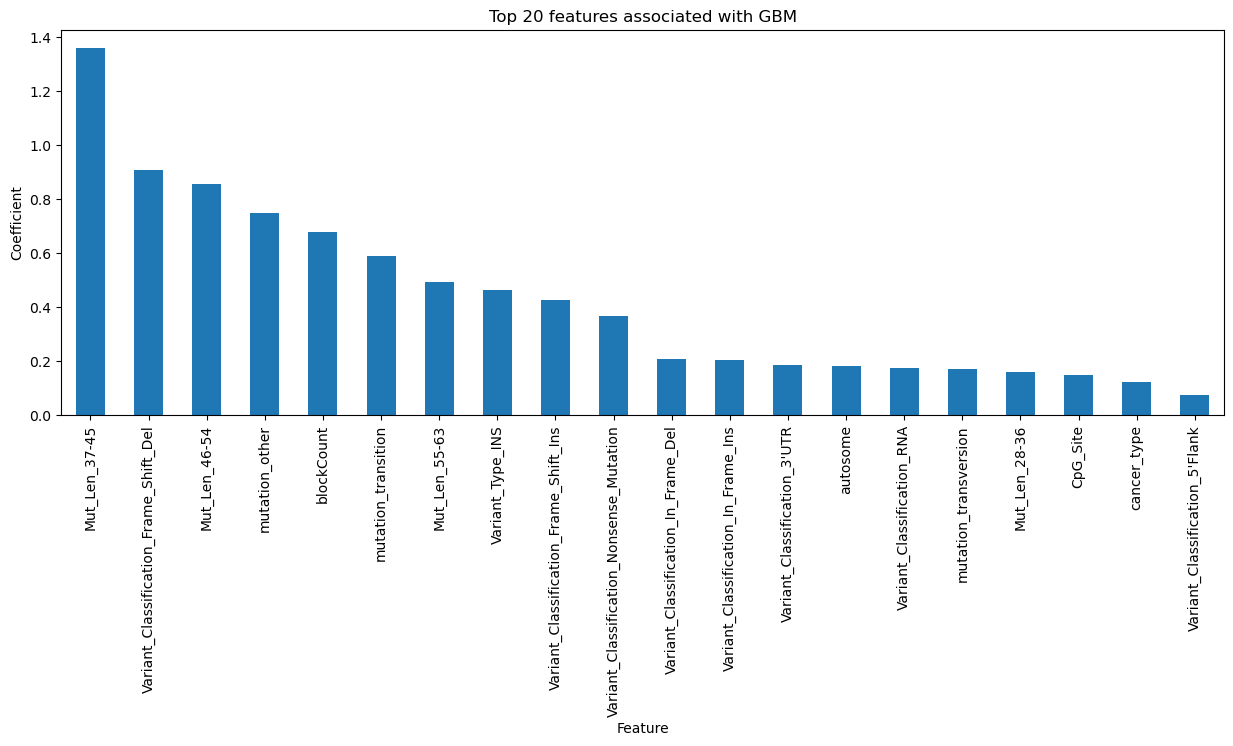

In [140]:
# find what words are most predictive of a GBM diagnosis

pos_coef = logreg_model.coef_[0]
# names of coefficients (words)
GBM_features = genetic_df.columns[:len(pos_coef)]

# Create a series of the coefficients and feature names
GBM_feature_count = pd.Series(pos_coef, index=GBM_features).sort_values(ascending=False)

# Plot the 20 most common features associated with GBM
GBM_feature_count.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 features associated with GBM")
plt.ylabel("Coefficient")
plt.xlabel("Feature")
plt.show()

## 5.1.2 Logistic Regression Evaluation


* Accuracy
* Precision
* Recall
* F1 Score
* Confusion Matrix
* ROC Curve and AUC 

In [458]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lr)

cf_matrix

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted LGG", "Predicted GBM"],
    index=["True LGG", "True GBM"],
)
cf_df

,Predicted LGG,Predicted GBM
True LGG,147,6879
True GBM,123,16516


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

# Accuracy and Classification Report


classification_report_str = classification_report(y_test, y_pred_lr)
print(f"Classification Report: {classification_report_str}")




Classification Report:               precision    recall  f1-score   support

           0       0.54      0.02      0.04      7026
           1       0.71      0.99      0.83     16639

    accuracy                           0.70     23665
   macro avg       0.63      0.51      0.43     23665
weighted avg       0.66      0.70      0.59     23665



In [430]:

accuracy = accuracy_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Accuracy: 0.7041200084512994
Recall: 0.9926077288298576
Precision: 0.7059628125667877


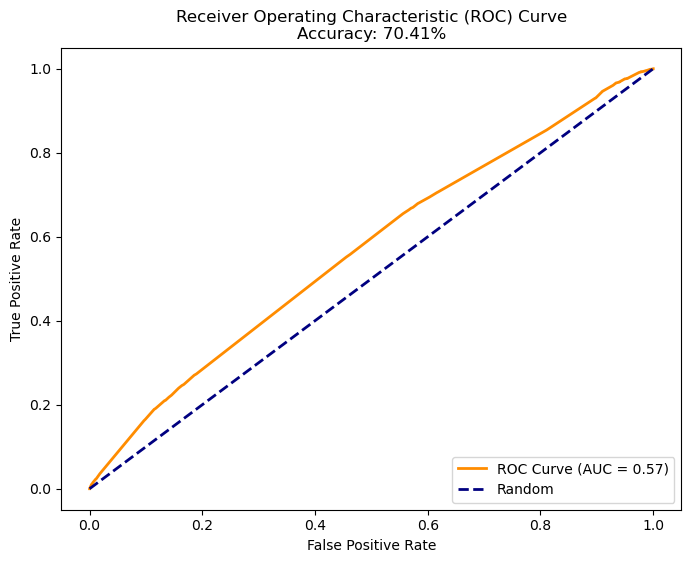

In [431]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr) 

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

## 5.2 Deicision Tree Classifier

In [420]:
from sklearn.tree import DecisionTreeClassifier


estimators = [('normalise', StandardScaler()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, verbose = True)

param_grid = [
            {'model': [DecisionTreeClassifier()], 
             'normalise': [StandardScaler(), None],
             'model__criterion': ['gini', 'entropy'],
             'model__max_depth': [10, 20, 30, 40],
             'model__min_samples_split': [2, 5, 10],
             'model__min_samples_leaf': [1, 2, 4]}
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 1)
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.0s
[Pipeline] ...

In [432]:
# Show the best parameters from the pipeline
fittedgrid.best_params_

{'model': DecisionTreeClassifier(),
 'model__criterion': 'entropy',
 'model__max_depth': 10,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10,
 'normalise': None}

In [470]:
# Instantiate the model
dtc_model = DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                   min_samples_leaf=4, min_samples_split=10)
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10)

In [471]:
# Make predictions on the test set
y_pred_dtc = dtc_model.predict(X_test)
y_prob_dtc = dtc_model.predict_proba(X_test)[:, 1]

### 5.2.2 Evaluating the Decision Tree Classifier Model
* Accuracy
* Classification Report
* Confusion Matrix
* Recall 
* Precision

In [478]:
# Determine the accuracy of the model
# Evaluate metrics
from sklearn.metrics import f1_score


accuracy = accuracy_score(y_test, y_pred_dtc)
precision = precision_score(y_test, y_pred_dtc)
recall = recall_score(y_test, y_pred_dtc)
f1 = f1_score(y_test, y_pred_dtc)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.7046270864145362
Precision: 0.7076929699944036
Recall: 0.9879800468778172
F1-score: 0.8246714156717166


In [474]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_dtc)

cf_matrix

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted LGG", "Predicted GBM"],
    index=["True LGG", "True GBM"],
)
cf_df

,Predicted LGG,Predicted GBM
True LGG,236,6790
True GBM,200,16439


In [ ]:
# Evaluate metrics
from sklearn.metrics import f1_score


accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7041200084512994
Recall: 0.9926077288298576
Precision: 0.7059628125667877


## 5.3 K-Nearest Neighbors

In [461]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

estimators = [('normalise', StandardScaler()),
              ('model', KNeighborsClassifier())]

pipe = Pipeline(estimators, verbose=True)

param_grid = [
            { 'model__n_neighbors' : [5, 7, 9, 11, 13, 15],
               'model__weights' : ['uniform', 'distance'],
               'model__metric' : ['minkowski', 'euclidean', 'manhattan']}
]
grid = GridSearchCV(pipe, param_grid, verbose=1, cv=3, n_jobs=-1)
fittedgrid_knn = grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.2s
[Pipeline] ....

In [465]:
fittedgrid_knn

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('model', KNeighborsClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid=[{'model__metric': ['minkowski', 'euclidean',
                                            'manhattan'],
                          'model__n_neighbors': [5, 7, 9, 11, 13, 15],
                          'model__weights': ['uniform', 'distance']}],
             verbose=1)

In [466]:
# Instantiate the model
knn_model = KNeighborsClassifier(n_neighbors=15, metric='manhattan', weights='distance')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [475]:
# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

In [479]:
# Evaluate metrics
from sklearn.metrics import f1_score


accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7050073948869638
Precision: 0.7075739339752407
Recall: 0.9893022417212572
F1-score: 0.8250507480640553


In [480]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_knn)

cf_matrix

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted LGG", "Predicted GBM"],
    index=["True LGG", "True GBM"],
)
cf_df

,Predicted LGG,Predicted GBM
True LGG,223,6803
True GBM,178,16461
